In [1107]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [1108]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:30<00:00,  4.21it/s]


In [1109]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [1110]:

prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

("load a csv file into a pandas in python. the file is named 'cs412_hw1_dataset.csv' and contains columns like 'species', 'island', 'sex', 'diet', 'year', 'life stage', 'body mass (g)', 'bill length (mm)', 'bill depth (mm)', 'flipper length (mm)', and 'health metrics'. \n",
 "you can load a csv file into a pandas dataframe in python using the pandas.read_csv() function. here's how you can do it for your specific csv file:pythoncopy codeimport pandas as pd\n\n# specify the file path\nfile_path = 'cs412_hw1_dataset.csv'\n\n# load the csv file into a pandas dataframe\ndf = pd.read_csv(file_path)\n\n# display the first few rows of the dataframe to verify the data has been loaded\nprint(df.head())\nthis code assumes that the csv file 'cs412_hw1_dataset.csv' is in the same directory as your python script or jupyter notebook. if the file is in a different directory, you can specify the full path to the file in the file_path variable.the pd.read_csv() function will automatically infer the colu

In [1111]:
print(prompts[0])
print("-----------")
print(answers[0])

load a csv file into a pandas in python. the file is named 'cs412_hw1_dataset.csv' and contains columns like 'species', 'island', 'sex', 'diet', 'year', 'life stage', 'body mass (g)', 'bill length (mm)', 'bill depth (mm)', 'flipper length (mm)', and 'health metrics'. 

-----------
you can load a csv file into a pandas dataframe in python using the pandas.read_csv() function. here's how you can do it for your specific csv file:pythoncopy codeimport pandas as pd

# specify the file path
file_path = 'cs412_hw1_dataset.csv'

# load the csv file into a pandas dataframe
df = pd.read_csv(file_path)

# display the first few rows of the dataframe to verify the data has been loaded
print(df.head())
this code assumes that the csv file 'cs412_hw1_dataset.csv' is in the same directory as your python script or jupyter notebook. if the file is in a different directory, you can specify the full path to the file in the file_path variable.the pd.read_csv() function will automatically infer the column na

In [1112]:
questions = [
    #####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]


questions = [q.lower() for q in questions] # Lower case version of the questions

In [1113]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [1114]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

# printing the most frequent words
print("Most frequent words:")
print(questions_TF_IDF.sum().sort_values(ascending=False).head(10))


Most frequent words:
the                1.977829
pts                1.921524
you                0.925474
hyperparameters    0.734257
dataset            0.716780
split              0.636640
10                 0.605766
with               0.563605
training           0.539783
and                0.529299
dtype: float64


In [1115]:
# Converting the dictionary to a DataFrame
refactored_data = []
for code, pairs in code2prompt_answer_pairs.items():
    vectorized_pairs = [(prompt.split(), answer.split()) for prompt, answer in pairs]
    refactored_data.append({'code': code, 'prompt_answer_pairs': vectorized_pairs})

df = pd.DataFrame(refactored_data)



In [1116]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


In [1117]:
df.describe()

,code,prompt_answer_pairs
count,123,123
unique,123,123
top,0031c86e-81f4-4eef-9e0e-28037abf9883,"[([load, a, csv, file, into, a, pandas, in, py..."
freq,1,1


In [1118]:
scores.describe()

,grade
count,144.000000
mean,91.965278
std,11.735079
min,15.000000
25%,89.000000
50%,95.000000
75%,99.000000
max,100.000000


In [1119]:
subset_columns = ['code']

# Delete duplicates
scores = scores.drop_duplicates(subset=subset_columns)

In [1120]:
scores.dropna(subset=['grade'], inplace=True)
scores.describe()

,grade
count,126.000000
mean,91.841270
std,12.262732
min,15.000000
25%,89.250000
50%,95.000000
75%,99.000000
max,100.000000


In [1121]:
df.dropna(subset=['code'], inplace=True)

In [1122]:
subset_columns = ['code']

# Delete duplicates
df = df.drop_duplicates(subset=subset_columns)

In [1123]:
df.describe()

,code,prompt_answer_pairs
count,123,123
unique,123,123
top,0031c86e-81f4-4eef-9e0e-28037abf9883,"[([load, a, csv, file, into, a, pandas, in, py..."
freq,1,1


#### Merging scores with features

In [1124]:
# join the scores with the df
df = df.merge(scores, on="code")

df.head()

,code,prompt_answer_pairs,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,"[([load, a, csv, file, into, a, pandas, in, py...",48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,"[([i, have, a, dataset, that, contains, the, f...",99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,"[([i, have, a, csv, file, data, with, columns:...",90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,"[([how, can, i, display, variable, names, in, ...",97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,"[([i, am, doing, a, machine, leraning, homewor...",100.0


In [1125]:
df.describe()

,grade
count,122.000000
mean,91.754098
std,12.419201
min,15.000000
25%,89.250000
50%,95.000000
75%,99.000000
max,100.000000


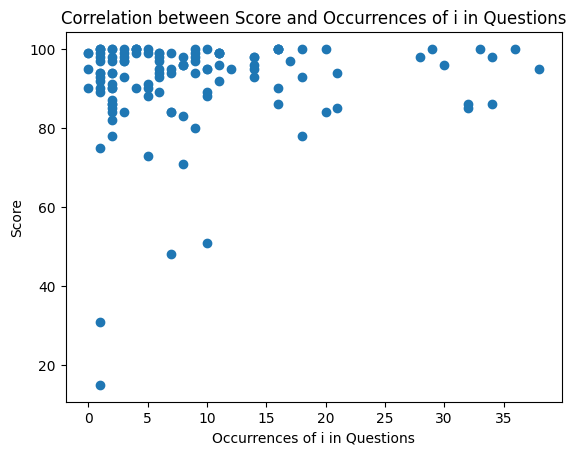

In [1126]:
## CHECKING THE NUMBER OF PROMPTS THAT CONTAIN THE WORD "I"
## PLOTTING THE CORRELATION BETWEEN THE NUMBER OF "I"s AND THE SCORES
## SINCE THE PEOPLE USE "I", TENDS TO CHAT WITH GPT IN MORE DAILY LANGUAGE, IT CAN BE A GOOD INDICATOR OF THE SCORES

#define a method for see the correlation with any given word


def see_word_correlation_with_word(word):
    count_word_per_code = {}
    for row in df.itertuples():
        count_word = sum(word in prompt for prompt, _ in row.prompt_answer_pairs)
        count_word_per_code[row.code] = count_word
    df_temp = df.copy()
    df_temp['count_word'] = df_temp['code'].map(count_word_per_code)

    plt.scatter(df_temp['count_word'], df['grade'])
    plt.title("Correlation between Score and Occurrences of " + word  +" in Questions")
    plt.xlabel("Occurrences of " + word +" in Questions")
    plt.ylabel('Score')
    plt.show()

see_word_correlation_with_word("i")


In [1127]:
# adding a new column named chat_length and assign it to the size of the prompt_answer_pairs
df["chat_length"] = df["prompt_answer_pairs"].apply(lambda x: len(x))
#sort by grade
df = df.sort_values(by=["grade"], ascending=False)

df.head()

,code,prompt_answer_pairs,grade,chat_length
39,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13
110,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35
62,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28
23,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21
69,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22


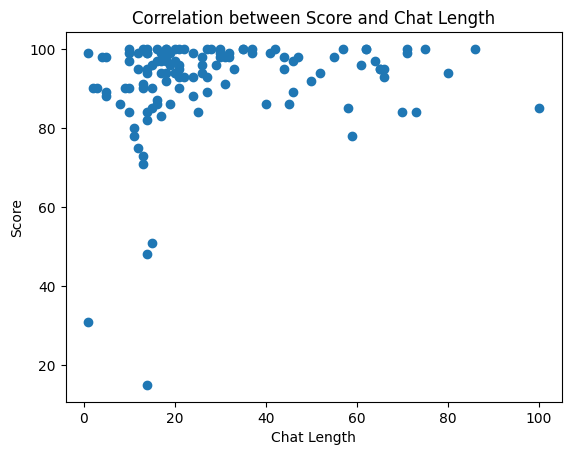

In [1128]:
# now, plot the correlation between the chat length and the scores
plt.scatter(df['chat_length'], df['grade'])
plt.title('Correlation between Score and Chat Length')
plt.xlabel('Chat Length')
plt.ylabel('Score')
plt.show()

In [1129]:
# Calculate the average answer length for each row
def calculate_average_answer_length(prompt_answer_pairs):
    total_length = sum(len(answer) for _, answer in prompt_answer_pairs)
    return total_length / len(prompt_answer_pairs) if prompt_answer_pairs else 0

df['average_answer_length'] = df['prompt_answer_pairs'].apply(calculate_average_answer_length)
df.head()
# Now your DataFrame 'df' will have a new column 'average_answer_length' with the calculated values


,code,prompt_answer_pairs,grade,chat_length,average_answer_length
39,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231
110,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857
62,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286
23,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143
69,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182


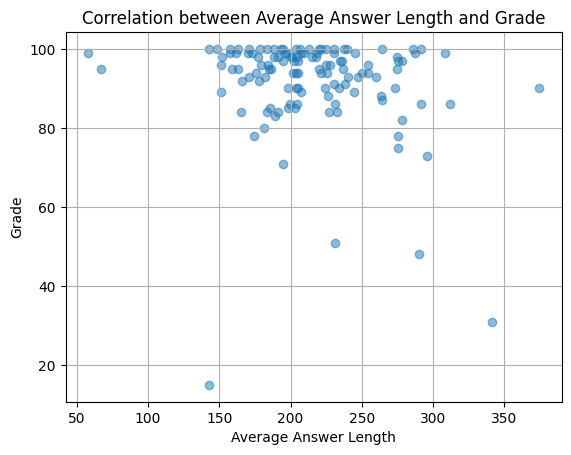

In [1130]:
# Scatter plot of 'average_answer_length' vs 'grade'
plt.scatter(df['average_answer_length'], df['grade'], alpha=0.5)  # Create a scatter plot
plt.title('Correlation between Average Answer Length and Grade')  # Chart title
plt.xlabel('Average Answer Length')  # X-axis label
plt.ylabel('Grade')  # Y-axis label
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot


In [1131]:
# Calculate the average prompt length for each row
def calculate_average_prompt_length(prompt_answer_pairs):
    total_length = sum(len(prompt) for prompt, _ in prompt_answer_pairs)
    return total_length / len(prompt_answer_pairs) if prompt_answer_pairs else 0

df['average_prompt_length'] = df['prompt_answer_pairs'].apply(calculate_average_prompt_length)
df.head()


,code,prompt_answer_pairs,grade,chat_length,average_answer_length,average_prompt_length
39,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231,54.384615
110,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857,70.428571
62,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286,30.464286
23,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143,37.857143
69,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182,19.954545


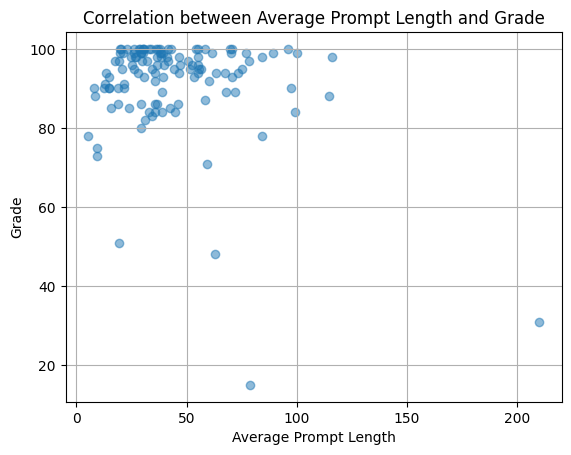

In [1132]:

# Scatter plot of 'average_prompt_length' vs 'grade'
plt.scatter(df['average_prompt_length'], df['grade'], alpha=0.5)  # Create a scatter plot
plt.title('Correlation between Average Prompt Length and Grade')  # Chart title
plt.xlabel('Average Prompt Length')  # X-axis label
plt.ylabel('Grade')  # Y-axis label
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot


In [1133]:
# Read the CSV file, specifying the data type for 'related_question' as integer
labeled_data_df = pd.read_csv("data/labeled_data/train_dataset.csv", sep="\t", dtype={'related_question': 'Int64'})

# Calculate the mode (most frequent value) of the 'related_question' column
mode_related_question = labeled_data_df['related_question'].mode().iloc[0]

# Convert mode to integer in case it's a float
mode_related_question = int(mode_related_question)

# Fill missing values in 'related_question' with the mode
labeled_data_df['related_question'].fillna(mode_related_question, inplace=True)

# Display the first 50 rows of the DataFrame
labeled_data_df.head(50)


,prompt,related_question
0,## 2) Load training dataset (5 pts)\r\n\r\n* ...,1
1,## 3) Understanding the dataset & Preprocessin...,2
2,"Set X & y, split data (5 pts)\r\n\r\n* Shuff...",3
3,Features and Correlations (10 pts)\r\n\r\n* Co...,4
4,Tune Hyperparameters (20 pts)\r\n* Choose 2 hy...,5
5,Re-train and plot the decision tree with the h...,6
6,Test your classifier on the test set (20 pts)\...,7
7,Find the information gain on the first split (...,8
8,How do I check for missing values in my dataset?,2
9,What should I do if I find missing values in m...,2


In [1134]:
#read the labeled data

X_train, X_test, y_train, y_test = train_test_split(labeled_data_df["prompt"], labeled_data_df["related_question"], test_size=0.2, random_state=42)
# and then vectorize the prompts
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# train the model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

def predict_question_number(prompt, clf):
    prompt = vectorizer.transform([prompt])
    print(clf.predict(prompt)[0])
    



Accuracy:  0.9732142857142857


In [1135]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


labeled_data_df['prompt'] = labeled_data_df['prompt'].str.lower()
X_train, X_test, y_train, y_test = train_test_split(labeled_data_df["prompt"], labeled_data_df["related_question"], test_size=0.2, random_state=42)
# and then vectorize the prompts
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)


clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

def predict_question_number(prompt, clf, vectorizer):
    prompt_vect = vectorizer.transform([prompt.lower()])
    return int(clf.predict(prompt_vect)[0])

new_prompt = "hi. need help machine learning class hw using palmer penguins dataset extended dataset kaggle. task build decision tree classifier."
predicted_question_number = predict_question_number(new_prompt, clf, vectorizer)
print("Predicted question number for the new prompt is:", predicted_question_number)



Accuracy:  0.875
Predicted question number for the new prompt is: 6


In [1136]:

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


# Define the function to process prompts and predict question numbers
def predict_questions_for_row(row, clf, vectorizer):
    predicted_questions = []
    for prompt, _ in row['prompt_answer_pairs']:
        # Remove stopwords from the prompt
        clean_prompt = [word for word in prompt if word.lower() not in ENGLISH_STOP_WORDS]
        # Convert the list of words back to a string
        prompt_str = ' '.join(clean_prompt)
        # Predict the question number
        qNo = predict_question_number(prompt_str, clf, vectorizer)
        predicted_questions.append(qNo)
    return predicted_questions

# Apply the function to each row and create the new column
df['predicted_questions'] = df.apply(lambda row: predict_questions_for_row(row, clf, vectorizer), axis=1)


In [1137]:
df.head()

,code,prompt_answer_pairs,grade,chat_length,average_answer_length,average_prompt_length,predicted_questions
39,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231,54.384615,"[1, 2, 1, 4, 3, 1, 4, 5, 6, 7, 1, 1, 1]"
110,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857,70.428571,"[1, 1, 1, 1, 1, 2, 1, 1, 3, 4, 4, 1, 4, 1, 1, ..."
62,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286,30.464286,"[1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, ..."
23,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143,37.857143,"[6, 6, 5, 1, 2, 2, 1, 4, 4, 4, 1, 3, 1, 4, 1, ..."
69,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182,19.954545,"[1, 1, 2, 1, 1, 4, 1, 4, 4, 1, 1, 4, 5, 1, 4, ..."


In [1138]:
all_prompts_dict =  {}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    # Initialize an array to hold the prompts for this row
    prompts = []
    
    # Iterate through the prompt_answer_pairs
    for pair in row['prompt_answer_pairs']:
        # pair[0] is the prompt part of the pair
        # Join the words of the prompt to form a string and add to the prompts array
        prompts.append(' '.join(pair[0]))
    
    # Add the prompts array to the dictionary with the code as the key
    all_prompts_dict[row['code']] = prompts

print(all_prompts_dict["0031c86e-81f4-4eef-9e0e-28037abf9883"][10])

i need to propose two hypothetical features that could enhance the predictive accuracy for the target variable 'health_metrics'. can you suggest two potential new features, explaining how they might be derived from the existing data or external sources, and their expected impact on the model's accuracy? also, provide a hypothetical example of how to calculate and show the correlations of these new features with the target variable using python. note that the target variable 'health_metrics' is categorical and has been numerically encoded."


In [1139]:
vectorizer = TfidfVectorizer()
all_prompts_list = [prompt for prompts in all_prompts_dict.values() for prompt in prompts]
vectorizer = vectorizer.fit(all_prompts_list + questions)
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head(9)

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1140]:
all_prompts_tf_idf = dict()
for code, user_prompts in all_prompts_dict.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    all_prompts_tf_idf[code] = prompts_TF_IDF

In [1141]:
all_prompts_tf_idf["58fcd378-aa29-4067-813c-bb4de525428e"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1142]:
all_prompts_tf_idf["58fcd378-aa29-4067-813c-bb4de525428e"].shape

(62, 5392)

In [1143]:
code2cosine = dict()
for code, user_prompts_tf_idf in all_prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [1144]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i+1}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)
question_mapping_scores.head()

,code,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,51f35201-da77-4b6d-a455-99cc84195c5c,0.098970,0.347525,0.491167,0.471499,0.428097,0.465230,0.367397,0.329175
1,e264c424-a241-43f7-acca-9fbbf21dc1c6,0.734173,0.564138,0.624917,0.554937,0.282107,0.308472,0.331415,0.553407
2,745bb746-6467-4146-8ef5-55f3ee3f589e,0.215211,0.408930,0.806130,0.581122,0.725508,0.842050,0.719979,0.457945
3,27de4332-d81f-47a2-b2a9-c0b023a30919,0.110764,0.219500,0.153400,0.968152,0.145553,0.151513,0.148156,0.353548
4,7b0ecddc-caa5-4b81-88ea-cd65a7270900,0.080509,0.114617,0.197419,0.271456,0.272832,0.208799,0.096772,0.144249


In [1145]:
# Merging the DataFrames on the 'code' column
df = pd.merge(df, question_mapping_scores, on='code', how='left')

# Display the head of the combined DataFrame
df.head()

,code,prompt_answer_pairs,grade,chat_length,average_answer_length,average_prompt_length,predicted_questions,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231,54.384615,"[1, 2, 1, 4, 3, 1, 4, 5, 6, 7, 1, 1, 1]",0.098970,0.347525,0.491167,0.471499,0.428097,0.465230,0.367397,0.329175
1,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857,70.428571,"[1, 1, 1, 1, 1, 2, 1, 1, 3, 4, 4, 1, 4, 1, 1, ...",0.734173,0.564138,0.624917,0.554937,0.282107,0.308472,0.331415,0.553407
2,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286,30.464286,"[1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, ...",0.215211,0.408930,0.806130,0.581122,0.725508,0.842050,0.719979,0.457945
3,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143,37.857143,"[6, 6, 5, 1, 2, 2, 1, 4, 4, 4, 1, 3, 1, 4, 1, ...",0.110764,0.219500,0.153400,0.968152,0.145553,0.151513,0.148156,0.353548
4,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182,19.954545,"[1, 1, 2, 1, 1, 4, 1, 4, 4, 1, 1, 4, 5, 1, 4, ...",0.080509,0.114617,0.197419,0.271456,0.272832,0.208799,0.096772,0.144249


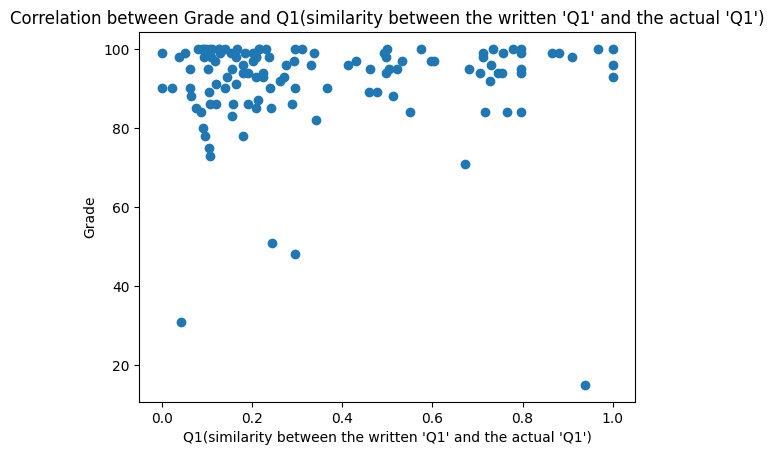

In [1146]:
plt.scatter(df['Q_1'], df['grade'])
plt.title("Correlation between Grade and Q1(similarity between the written 'Q1' and the actual 'Q1')")
plt.xlabel("Q1(similarity between the written 'Q1' and the actual 'Q1')")
plt.ylabel('Grade')
plt.show()

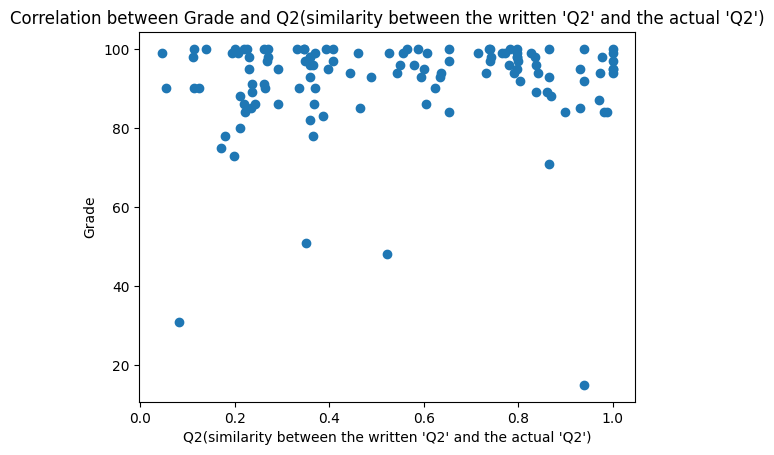

In [1147]:
plt.scatter(df['Q_2'], df['grade'])
plt.title("Correlation between Grade and Q2(similarity between the written 'Q2' and the actual 'Q2')")
plt.xlabel("Q2(similarity between the written 'Q2' and the actual 'Q2')")
plt.ylabel('Grade')
plt.show()

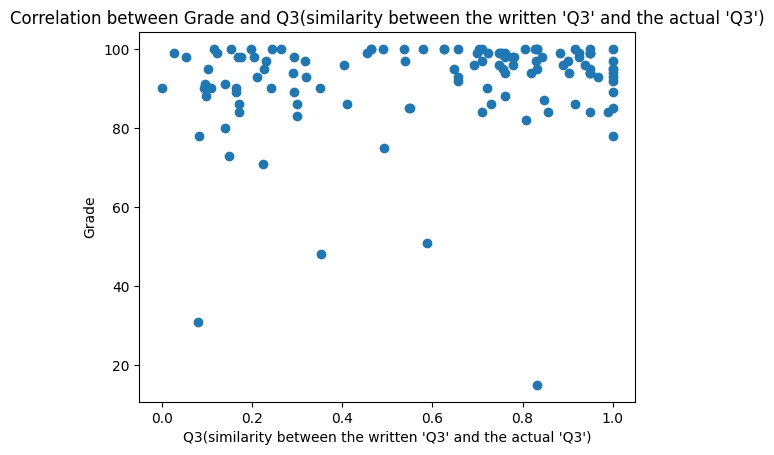

In [1148]:
plt.scatter(df['Q_3'], df['grade'])
plt.title("Correlation between Grade and Q3(similarity between the written 'Q3' and the actual 'Q3')")
plt.xlabel("Q3(similarity between the written 'Q3' and the actual 'Q3')")
plt.ylabel('Grade')
plt.show()

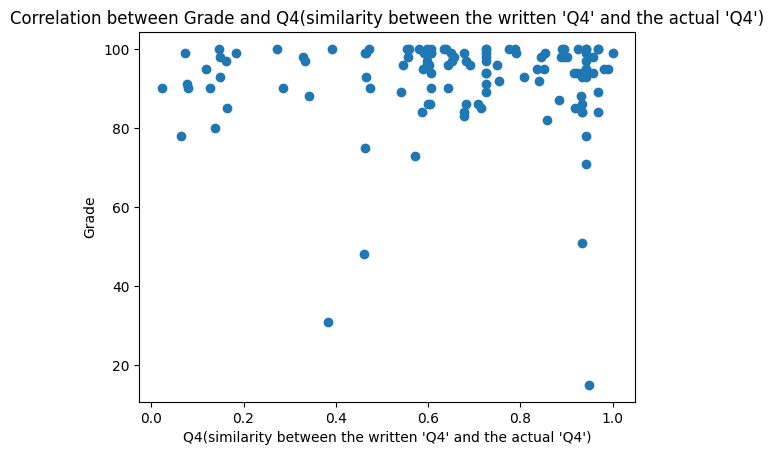

In [1149]:
plt.scatter(df['Q_4'], df['grade'])
plt.title("Correlation between Grade and Q4(similarity between the written 'Q4' and the actual 'Q4')")
plt.xlabel("Q4(similarity between the written 'Q4' and the actual 'Q4')")
plt.ylabel('Grade')
plt.show()

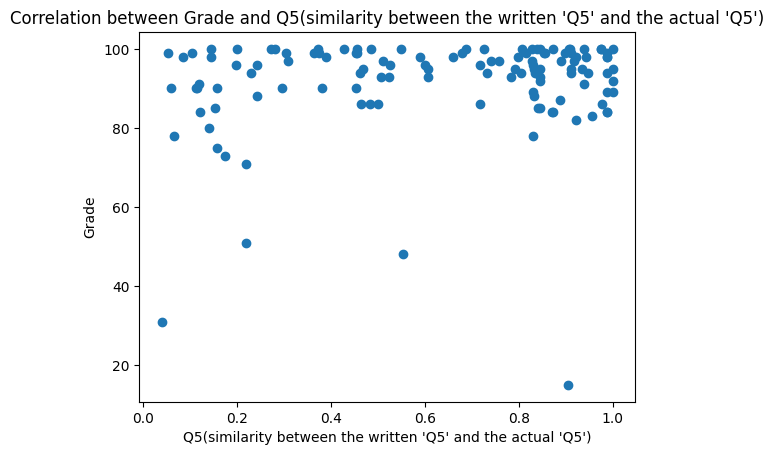

In [1150]:
plt.scatter(df['Q_5'], df['grade'])
plt.title("Correlation between Grade and Q5(similarity between the written 'Q5' and the actual 'Q5')")
plt.xlabel("Q5(similarity between the written 'Q5' and the actual 'Q5')")
plt.ylabel('Grade')
plt.show()

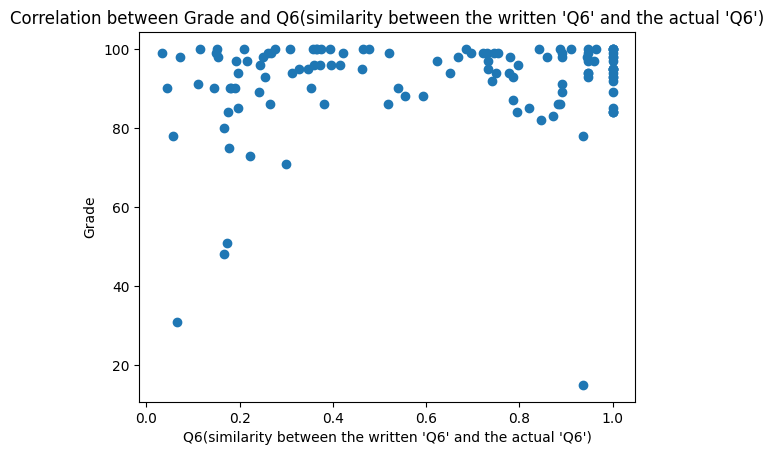

In [1151]:
plt.scatter(df['Q_6'], df['grade'])
plt.title("Correlation between Grade and Q6(similarity between the written 'Q6' and the actual 'Q6')")
plt.xlabel("Q6(similarity between the written 'Q6' and the actual 'Q6')")
plt.ylabel('Grade')
plt.show()

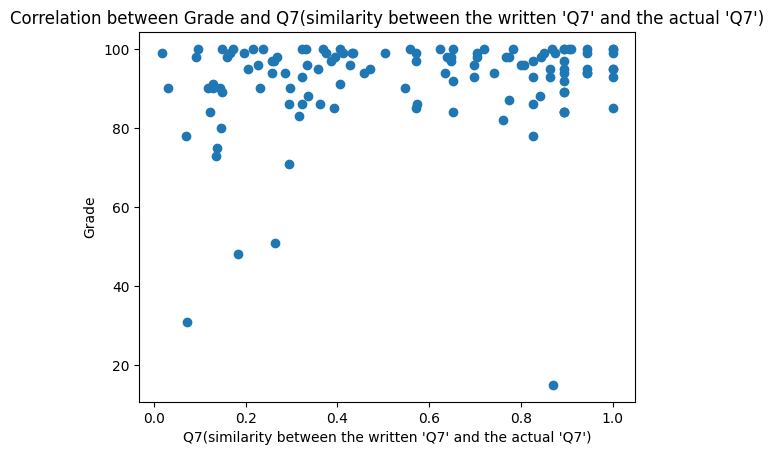

In [1152]:
plt.scatter(df['Q_7'], df['grade'])
plt.title("Correlation between Grade and Q7(similarity between the written 'Q7' and the actual 'Q7')")
plt.xlabel("Q7(similarity between the written 'Q7' and the actual 'Q7')")
plt.ylabel('Grade')
plt.show()

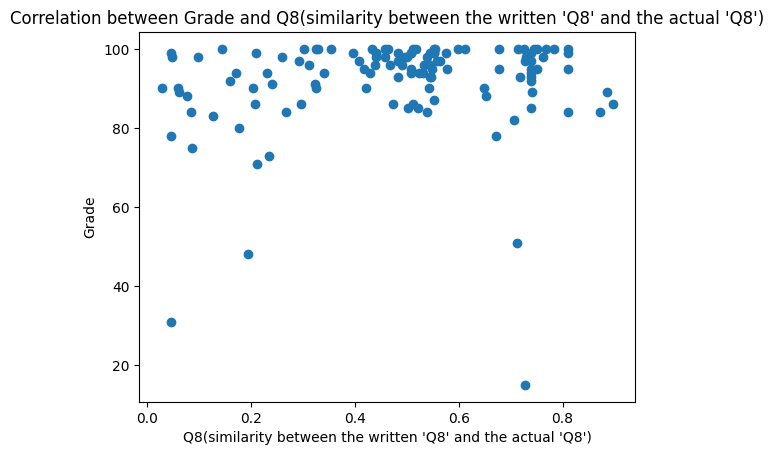

In [1153]:
plt.scatter(df['Q_8'], df['grade'])
plt.title("Correlation between Grade and Q8(similarity between the written 'Q8' and the actual 'Q8')")
plt.xlabel("Q8(similarity between the written 'Q8' and the actual 'Q8')")
plt.ylabel('Grade')
plt.show()

In [1154]:
from collections import Counter, defaultdict

# Assuming df is your DataFrame containing 'code' and 'predicted_questions' columns

# Initialize code2question_arrays with a list of 8 zeros for each code
code2question_arrays = defaultdict(lambda: [0] * 8)

for index, row in df.iterrows():
    code = row['code']
    predicted_questions = row['predicted_questions']
    
    # Increment the count for each question
    for question in predicted_questions:
        if 1 <= question <= 8:  # Ensure the question number is within the range
            code2question_arrays[code][int(question) - 1] += 1


In [1155]:
# Create new columns for each question count
for i in range(1, 9):
    df[f'Q{i}_count'] = 0

# Populate the new columns with data from code2question_arrays
for index, row in df.iterrows():
    code = row['code']
    if code in code2question_arrays:
        question_counts = code2question_arrays[code]
        for i in range(1, 9):
            df.at[index, f'Q{i}_count'] = question_counts[i-1]

# Display the updated DataFrame
df.head()

,code,prompt_answer_pairs,grade,chat_length,average_answer_length,average_prompt_length,predicted_questions,Q_1,Q_2,Q_3,...,Q_7,Q_8,Q1_count,Q2_count,Q3_count,Q4_count,Q5_count,Q6_count,Q7_count,Q8_count
0,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231,54.384615,"[1, 2, 1, 4, 3, 1, 4, 5, 6, 7, 1, 1, 1]",0.098970,0.347525,0.491167,...,0.367397,0.329175,6,1,1,2,1,1,1,0
1,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857,70.428571,"[1, 1, 1, 1, 1, 2, 1, 1, 3, 4, 4, 1, 4, 1, 1, ...",0.734173,0.564138,0.624917,...,0.331415,0.553407,22,3,1,4,1,0,3,1
2,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286,30.464286,"[1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, ...",0.215211,0.408930,0.806130,...,0.719979,0.457945,17,4,1,1,1,1,2,1
3,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143,37.857143,"[6, 6, 5, 1, 2, 2, 1, 4, 4, 4, 1, 3, 1, 4, 1, ...",0.110764,0.219500,0.153400,...,0.148156,0.353548,8,2,2,5,1,3,0,0
4,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182,19.954545,"[1, 1, 2, 1, 1, 4, 1, 4, 4, 1, 1, 4, 5, 1, 4, ...",0.080509,0.114617,0.197419,...,0.096772,0.144249,15,1,0,5,1,0,0,0


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

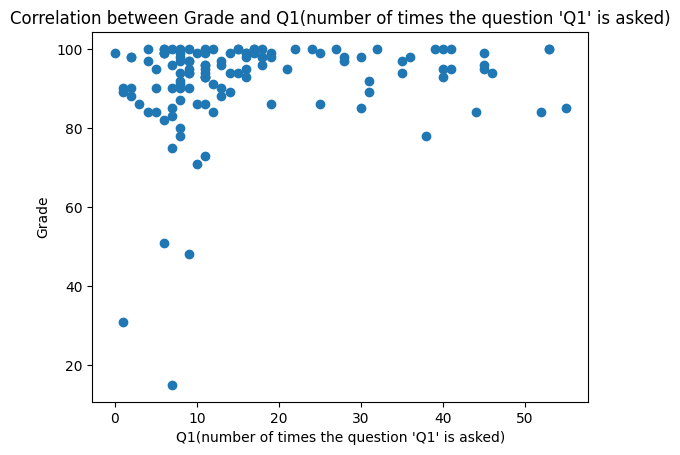

In [1156]:
plt.scatter(df['Q1_count'], df['grade'])
plt.title("Correlation between Grade and Q1(number of times the question 'Q1' is asked)")
plt.xlabel("Q1(number of times the question 'Q1' is asked)")
plt.ylabel('Grade')
plt.show()

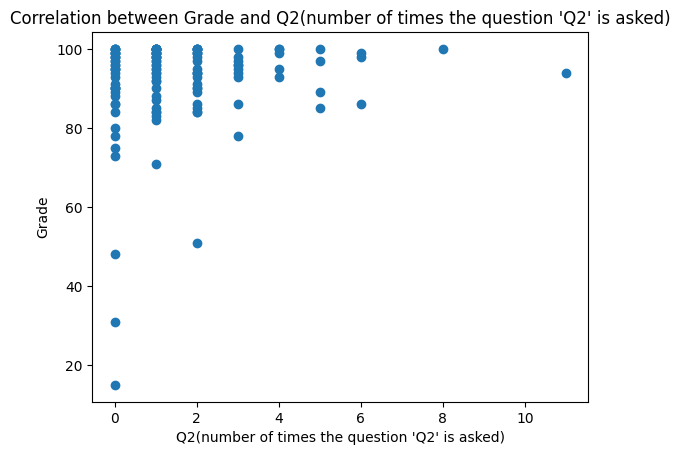

In [1157]:
plt.scatter(df['Q2_count'], df['grade'])
plt.title("Correlation between Grade and Q2(number of times the question 'Q2' is asked)")
plt.xlabel("Q2(number of times the question 'Q2' is asked)")
plt.ylabel('Grade')
plt.show()

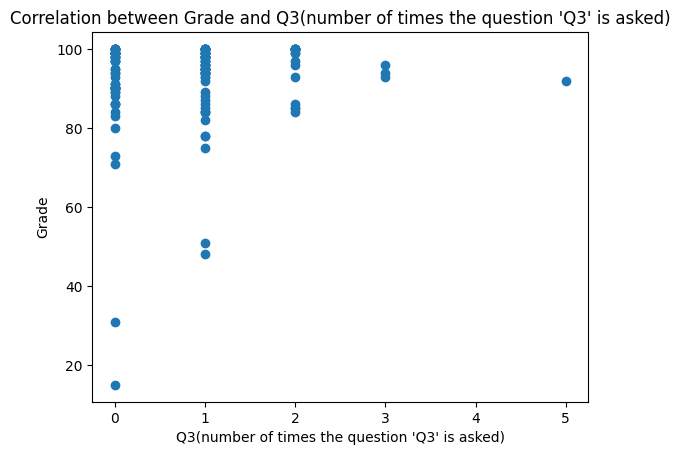

In [1158]:
plt.scatter(df['Q3_count'], df['grade'])
plt.title("Correlation between Grade and Q3(number of times the question 'Q3' is asked)")
plt.xlabel("Q3(number of times the question 'Q3' is asked)")
plt.ylabel('Grade')
plt.show()

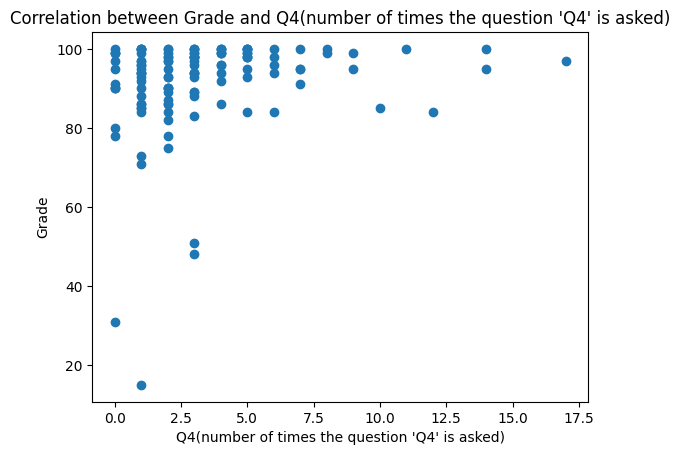

In [1159]:
plt.scatter(df['Q4_count'], df['grade'])
plt.title("Correlation between Grade and Q4(number of times the question 'Q4' is asked)")
plt.xlabel("Q4(number of times the question 'Q4' is asked)")
plt.ylabel('Grade')
plt.show()

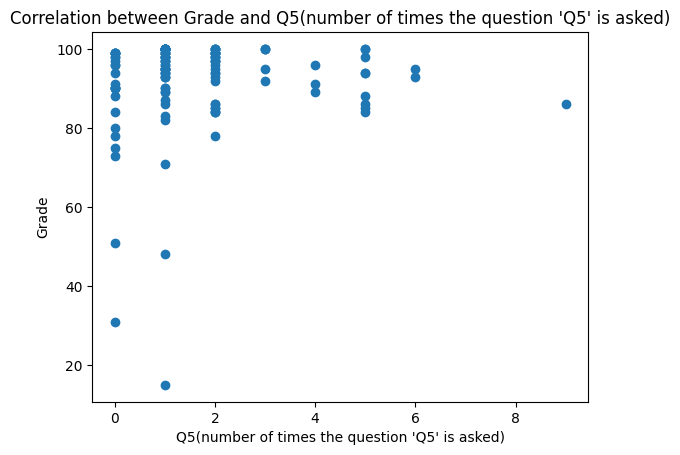

In [1160]:
plt.scatter(df['Q5_count'], df['grade'])
plt.title("Correlation between Grade and Q5(number of times the question 'Q5' is asked)")
plt.xlabel("Q5(number of times the question 'Q5' is asked)")
plt.ylabel('Grade')
plt.show()

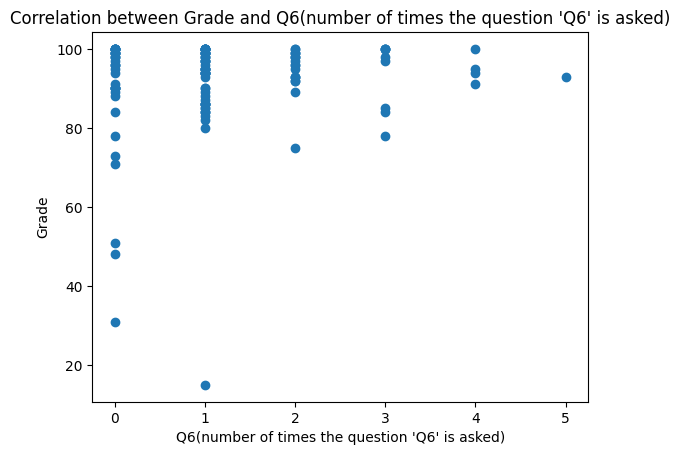

In [1161]:
plt.scatter(df['Q6_count'], df['grade'])
plt.title("Correlation between Grade and Q6(number of times the question 'Q6' is asked)")
plt.xlabel("Q6(number of times the question 'Q6' is asked)")
plt.ylabel('Grade')
plt.show()

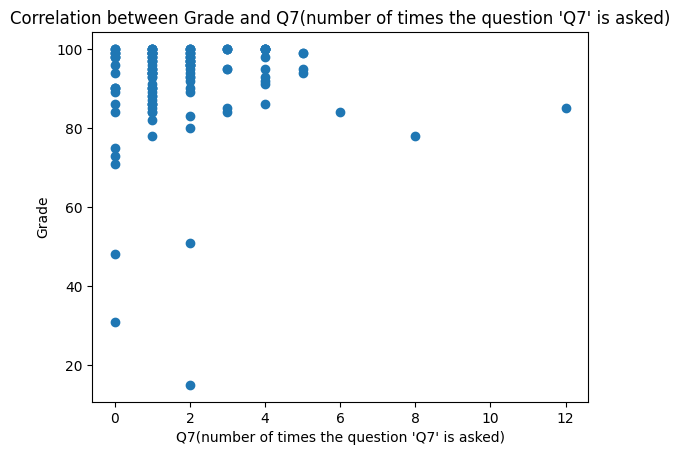

In [1162]:
plt.scatter(df['Q7_count'], df['grade'])
plt.title("Correlation between Grade and Q7(number of times the question 'Q7' is asked)")
plt.xlabel("Q7(number of times the question 'Q7' is asked)")
plt.ylabel('Grade')
plt.show()

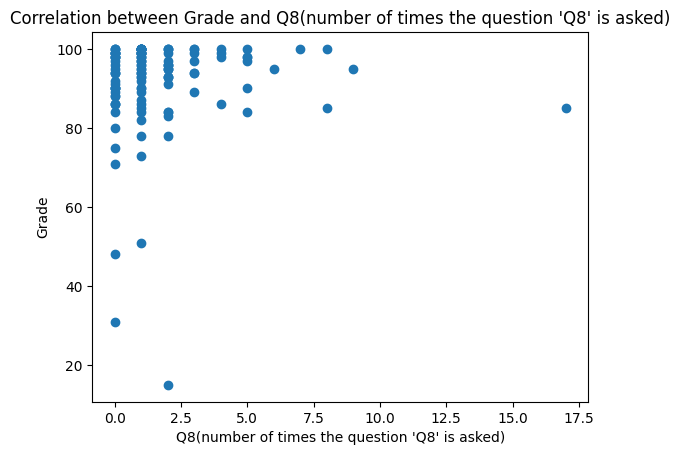

In [1163]:
plt.scatter(df['Q8_count'], df['grade'])
plt.title("Correlation between Grade and Q8(number of times the question 'Q8' is asked)")
plt.xlabel("Q8(number of times the question 'Q8' is asked)")
plt.ylabel('Grade')
plt.show()

In [1164]:

# Step 1: Filter to find persons with a score of 100
top_performers_df = df[df['grade'] == 100]

# Step 2: Separately combine their prompts and answers
combined_prompts = ' '.join([' '.join(pair[0]) for _, row in top_performers_df.iterrows() for pair in row['prompt_answer_pairs']])
combined_answers = ' '.join([' '.join(pair[1]) for _, row in top_performers_df.iterrows() for pair in row['prompt_answer_pairs']])

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the combined prompts and answers
vectorizer.fit([combined_prompts, combined_answers])

# Step 3: Calculate similarity for each row
def calculate_similarity(text, combined_text):
    text_tfidf = vectorizer.transform([text])
    combined_text_tfidf = vectorizer.transform([combined_text])
    return cosine_similarity(text_tfidf, combined_text_tfidf)[0][0]

# Apply similarity calculation for each row
df['similarity_to_top_prompts'] = df.apply(lambda row: calculate_similarity(' '.join(' '.join(pair[0]) for pair in row['prompt_answer_pairs']), combined_prompts), axis=1)
df['similarity_to_top_answers'] = df.apply(lambda row: calculate_similarity(' '.join(' '.join(pair[1]) for pair in row['prompt_answer_pairs']), combined_answers), axis=1)

# View the DataFrame
df.head()

,code,prompt_answer_pairs,grade,chat_length,average_answer_length,average_prompt_length,predicted_questions,Q_1,Q_2,Q_3,...,Q1_count,Q2_count,Q3_count,Q4_count,Q5_count,Q6_count,Q7_count,Q8_count,similarity_to_top_prompts,similarity_to_top_answers
0,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231,54.384615,"[1, 2, 1, 4, 3, 1, 4, 5, 6, 7, 1, 1, 1]",0.098970,0.347525,0.491167,...,6,1,1,2,1,1,1,0,0.884492,0.957283
1,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857,70.428571,"[1, 1, 1, 1, 1, 2, 1, 1, 3, 4, 4, 1, 4, 1, 1, ...",0.734173,0.564138,0.624917,...,22,3,1,4,1,0,3,1,0.893492,0.964158
2,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286,30.464286,"[1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, ...",0.215211,0.408930,0.806130,...,17,4,1,1,1,1,2,1,0.798383,0.901047
3,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143,37.857143,"[6, 6, 5, 1, 2, 2, 1, 4, 4, 4, 1, 3, 1, 4, 1, ...",0.110764,0.219500,0.153400,...,8,2,2,5,1,3,0,0,0.672848,0.752413
4,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182,19.954545,"[1, 1, 2, 1, 1, 4, 1, 4, 4, 1, 1, 4, 5, 1, 4, ...",0.080509,0.114617,0.197419,...,15,1,0,5,1,0,0,0,0.555274,0.936004


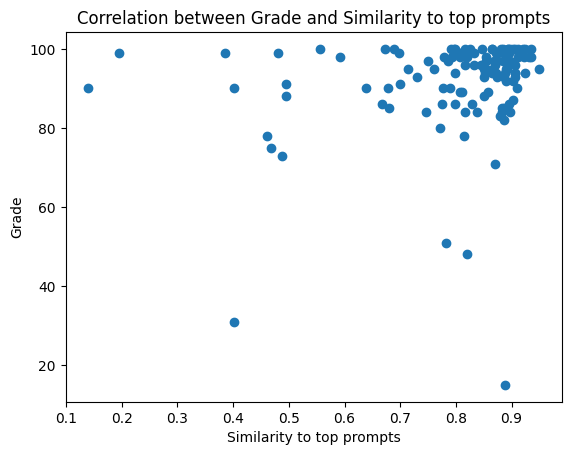

In [1165]:
plt.scatter(df['similarity_to_top_prompts'], df['grade'])
plt.title('Correlation between Grade and Similarity to top prompts')
plt.xlabel('Similarity to top prompts')
plt.ylabel('Grade')
plt.show()

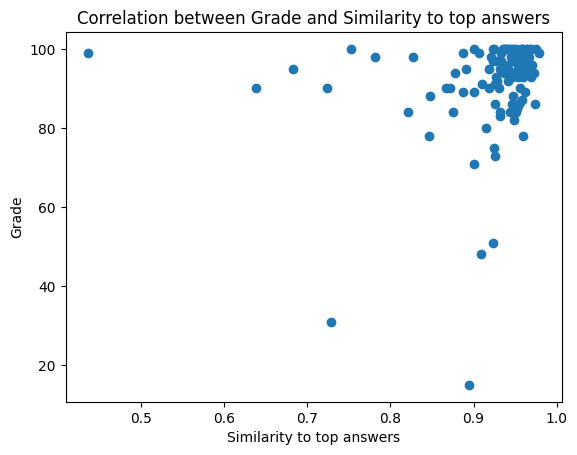

In [1166]:
plt.scatter(df['similarity_to_top_answers'], df['grade'])
plt.title('Correlation between Grade and Similarity to top answers')
plt.xlabel('Similarity to top answers')
plt.ylabel('Grade')
plt.show()

In [1167]:
import re

keywords2search = ["error", "no", "thank", "next", "Entropy"]

# Adjusted function to count occurrences of a keyword in a list of prompts
def count_keyword_in_prompts(prompts, keyword):
    return sum(len(re.findall(rf"\b{keyword}\b", ' '.join(prompt))) for prompt, _ in prompts)

# Iterate over each row to count keywords in each prompt
for index, row in df.iterrows():
    for kw in keywords2search:
        df.at[index, f"count_{kw}"] = count_keyword_in_prompts(row['prompt_answer_pairs'], kw)

# Display the DataFrame
df.head()

,code,prompt_answer_pairs,grade,chat_length,average_answer_length,average_prompt_length,predicted_questions,Q_1,Q_2,Q_3,...,Q6_count,Q7_count,Q8_count,similarity_to_top_prompts,similarity_to_top_answers,count_error,count_no,count_thank,count_next,count_Entropy
0,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13,237.769231,54.384615,"[1, 2, 1, 4, 3, 1, 4, 5, 6, 7, 1, 1, 1]",0.098970,0.347525,0.491167,...,1,1,0,0.884492,0.957283,0.0,0.0,3.0,0.0,0.0
1,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35,194.942857,70.428571,"[1, 1, 1, 1, 1, 2, 1, 1, 3, 4, 4, 1, 4, 1, 1, ...",0.734173,0.564138,0.624917,...,0,3,1,0.893492,0.964158,3.0,4.0,0.0,0.0,0.0
2,745bb746-6467-4146-8ef5-55f3ee3f589e,"[([ä±, have, a, dataset, named, df, and, ä±, w...",100.0,28,219.964286,30.464286,"[1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, ...",0.215211,0.408930,0.806130,...,1,2,1,0.798383,0.901047,2.0,0.0,0.0,0.0,0.0
3,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21,178.857143,37.857143,"[6, 6, 5, 1, 2, 2, 1, 4, 4, 4, 1, 3, 1, 4, 1, ...",0.110764,0.219500,0.153400,...,3,0,0,0.672848,0.752413,0.0,0.0,0.0,0.0,0.0
4,7b0ecddc-caa5-4b81-88ea-cd65a7270900,"[([what, do, we, mean, by, variable, names, bo...",100.0,22,263.818182,19.954545,"[1, 1, 2, 1, 1, 4, 1, 4, 4, 1, 1, 4, 5, 1, 4, ...",0.080509,0.114617,0.197419,...,0,0,0,0.555274,0.936004,0.0,1.0,0.0,0.0,0.0


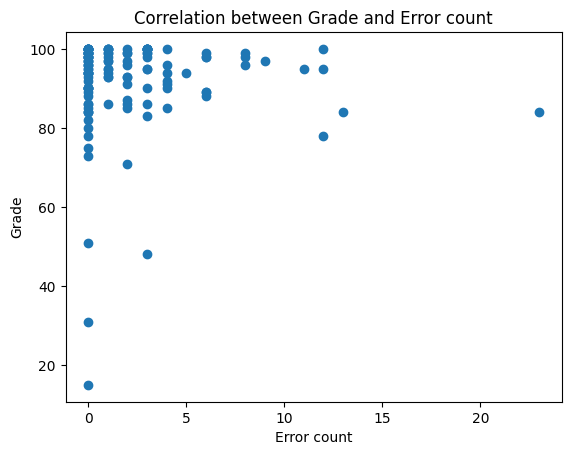

In [1168]:
plt.scatter(df['count_error'], df['grade'])
plt.title('Correlation between Grade and Error count')
plt.xlabel('Error count')
plt.ylabel('Grade')
plt.show()

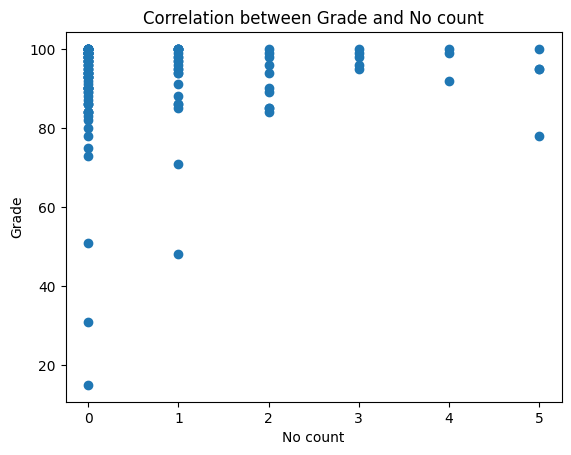

In [1169]:
plt.scatter(df['count_no'], df['grade'])
plt.title('Correlation between Grade and No count')
plt.xlabel('No count')
plt.ylabel('Grade')
plt.show()

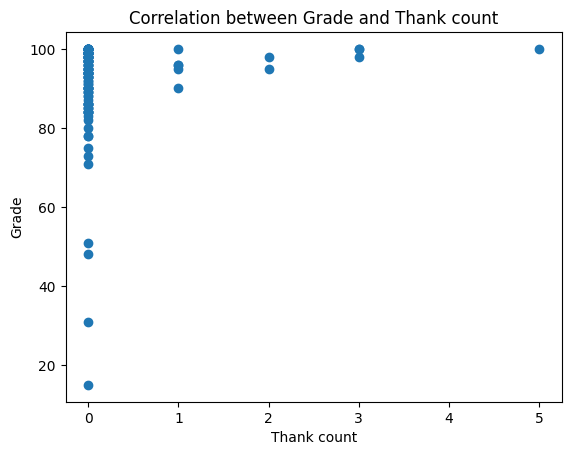

In [1170]:
plt.scatter(df['count_thank'], df['grade'])
plt.title('Correlation between Grade and Thank count')
plt.xlabel('Thank count')
plt.ylabel('Grade')
plt.show()

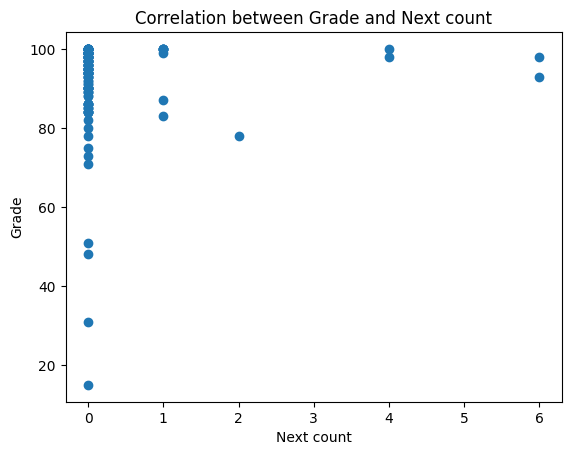

In [1171]:
plt.scatter(df['count_next'], df['grade'])
plt.title('Correlation between Grade and Next count')
plt.xlabel('Next count')
plt.ylabel('Grade')
plt.show()

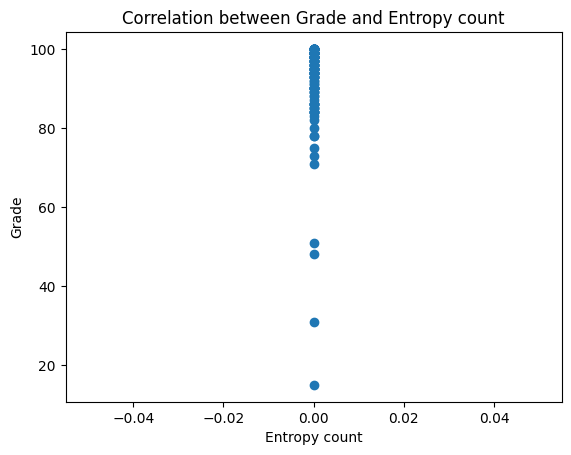

In [1172]:
plt.scatter(df['count_Entropy'], df['grade'])
plt.title('Correlation between Grade and Entropy count')
plt.xlabel('Entropy count')
plt.ylabel('Grade')
plt.show()

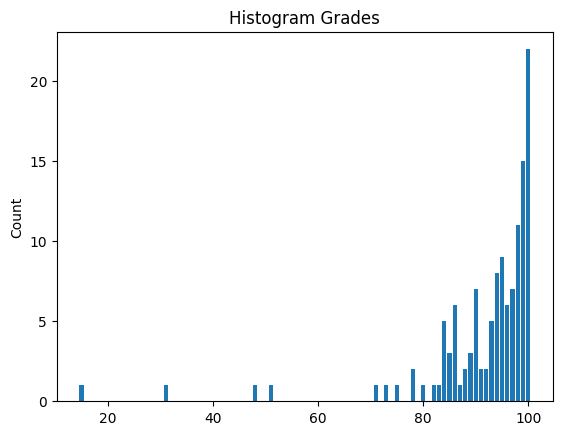

In [1173]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

#### Train/Test split

In [1174]:
df=df.dropna(subset=['grade'])

In [1175]:
X = df.drop(['grade', 'code','prompt_answer_pairs','predicted_questions'], axis=1)  # Features (all columns except 'grade' and 'code')
y = df['grade']  # Target (the 'grade' column)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


In [1176]:
from sklearn.feature_selection import SelectKBest, f_regression

# Apply SelectKBest class to extract top k best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(10, 'Score'))  # Print best features


                        Specs     Score
2       average_prompt_length  8.479671
14                   Q4_count  4.218409
0                 chat_length  3.150194
11                   Q1_count  3.092388
19  similarity_to_top_prompts  2.427549
1       average_answer_length  2.248024
20  similarity_to_top_answers  2.030106
13                   Q3_count  1.889275
12                   Q2_count  1.865253
23                count_thank  1.803288


In [1177]:
X = X = df[['average_prompt_length', 'Q4_count', 'chat_length','Q1_count','similarity_to_top_prompts']]  
y = df['grade']  # Target (the 'grade' column)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

In [1178]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=10, random_state=0)

In [1179]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 160.66170687639533
Node 1 has MSE 123.77766927083394
Node 2 has MSE 295.6218787158159
Node 3 has MSE 45.5625
Node 4 has MSE 23.265306122450056
Node 5 has MSE 0.8888888888895963
Node 6 has MSE 0.0
Node 7 has MSE 1.0
Node 8 has MSE 0.0
Node 9 has MSE 0.0
Node 10 has MSE 21.338842975206717
Node 11 has MSE 0.9166666666660603
Node 12 has MSE 0.22222222222444543
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 0.22222222222080745
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 21.360000000000582
Node 19 has MSE 2.8888888888895963
Node 20 has MSE 0.0
Node 21 has MSE 0.25
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 4.0
Node 25 has MSE 0.0
Node 26 has MSE 0.0
Node 27 has MSE 1.0
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 509.8698224852078
Node 31 has MSE 179.90972222222263
Node 32 has MSE 267.55555555555475
Node 33 has MSE 81.0
Node 34 has MSE 0.0
Node 35 has MSE 0.0
Node 36 has MSE 0.0
Node 37 has MSE 76.54320987654319
Node 38 has MSE 0.0


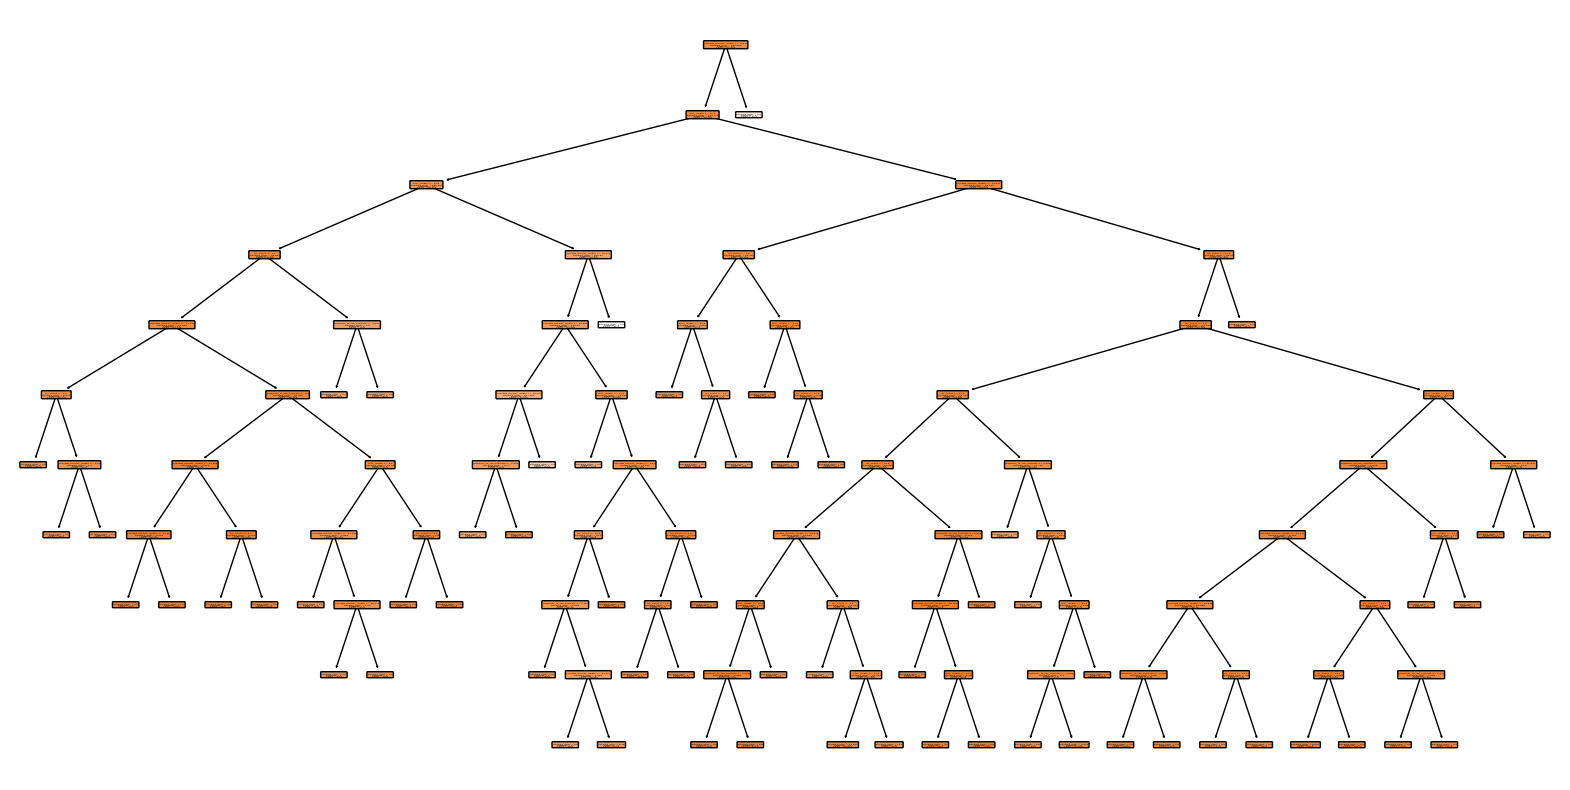

In [1180]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming regressor is your trained DecisionTreeRegressor and X.columns are the feature names
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()


#### Predicting and Analyzing 

In [1181]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 3.8907418637558115
MSE TEST: 180.2694194540561
R2 Train: 0.975783016753649
R2 TEST: -0.4757988467827867


In [1182]:
for score,real in zip(y_test_pred,y_test.values):
    print("Predicted: ", score, "Real: ", real)


Predicted:  96.0 Real:  100.0
Predicted:  94.33333333333333 Real:  98.0
Predicted:  94.52941176470588 Real:  97.0
Predicted:  90.0 Real:  90.0
Predicted:  100.0 Real:  100.0
Predicted:  95.0 Real:  98.0
Predicted:  99.0 Real:  95.0
Predicted:  97.0 Real:  84.0
Predicted:  86.0 Real:  99.0
Predicted:  95.0 Real:  96.0
Predicted:  94.0 Real:  96.0
Predicted:  99.0 Real:  48.0
Predicted:  94.33333333333333 Real:  100.0
Predicted:  91.0 Real:  90.0
Predicted:  95.0 Real:  84.0
Predicted:  93.0 Real:  100.0
Predicted:  94.52941176470588 Real:  93.0
Predicted:  100.0 Real:  96.0
Predicted:  88.0 Real:  75.0
Predicted:  71.0 Real:  100.0
Predicted:  99.0 Real:  99.0
Predicted:  95.0 Real:  98.0
Predicted:  82.0 Real:  95.0
Predicted:  94.52941176470588 Real:  86.0
Predicted:  94.52941176470588 Real:  99.0
